In [4]:
!pip install -U dspy
!pip install fal_client

In [5]:
import dspy
import os
from PIL import Image
from io import BytesIO
import requests
import fal_client

from dotenv import load_dotenv
load_dotenv()

# import display
from IPython.display import display

lm = dspy.LM(model="gemini/gemini-2.5-pro",api_key=os.environ["GEMINI_API_KEY"])
dspy.settings.configure(lm=lm)

def generate_image(prompt):
    request_id = fal_client.submit(
        "fal-ai/imagen4/preview",
        arguments={
            "prompt": prompt
        },
    ).request_id

    result = fal_client.result("fal-ai/imagen4/preview", request_id)
    url = result["images"][0]["url"]

    return dspy.Image.from_url(url)

def display_image(image):
    url = image.url
    # download the image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # display at 25% of original size
    display(image.resize((image.width // 4, image.height // 4)))

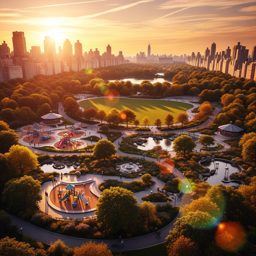

current prompt: 
new york central park. Public park landscape design and landscaping showcasing recreational 
concepts incorporating walking paths playground facilities natural vegetation water features 
pavilions and community-focused outdoor environmental design for public green spaces, 
rendered in the style of classicism, warm golden hour amber orange red tones cozy intimate, 
luminous glow soft radiant halos warm light emanation, long shot wide view subject extensive 
surrounding environment distant perspective

Subject Match: ✓ - The subject is a perfect match. The image clearly shows a large public park resembling Central Park, complete with the New York skyline, walking paths, playgrounds, water features, and pavilions as requested.
Art Type Match: ✓ - The art type is a good match. The image is a high-quality digital rendering that fits the descriptive nature of the prompt.
Art Movement Match: ✗ - The art movement of Classicism is not reflected in the image's core landscape des

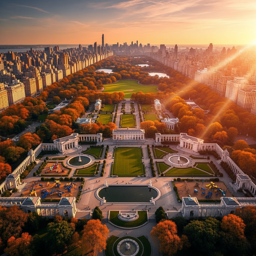

current prompt: Aerial long shot of New York's Central Park, reimagined in the landscape design style of Classicism. The park features highly symmetrical layouts, geometric parterres, formal gardens, and straight axial walking paths. Ornate classical pavilions and statues are placed with precision. The scene includes playground facilities and water features designed as formal basins. The entire landscape is bathed in the warm, cozy light of the golden hour, with amber, orange, and red tones creating a luminous glow and soft radiant halos. Wide view showing the extensive park environment against the distant city skyline.
✓ All components match perfectly!
Subject: The subject is a perfect match. The image depicts Central Park with the requested recreational facilities (playgrounds, paths, pavilions, water features) all integrated into the new design, with the iconic New York skyline providing context.
Art Type: The art type is a perfect match. The image is a high-quality, detailed digita

In [6]:
initial_prompt = """
new york central park. Public park landscape design and landscaping showcasing recreational 
concepts incorporating walking paths playground facilities natural vegetation water features 
pavilions and community-focused outdoor environmental design for public green spaces, 
rendered in the style of classicism, warm golden hour amber orange red tones cozy intimate, 
luminous glow soft radiant halos warm light emanation, long shot wide view subject extensive 
surrounding environment distant perspective
"""
current_prompt = initial_prompt

check_and_revise_prompt = dspy.ChainOfThought("""
desired_prompt: str, 
current_image: dspy.Image, 
current_prompt: str,
previous_attempts: str -> 
reasoning: str,

overall_prompt_match: bool,
subject_match: bool,
art_type_match: bool,
art_style_match: bool,
art_movement_match: bool,

has_conflicting_elements: bool,
conflict_description: str,

overall_prompt_match_feedback: str,
subject_feedback: str,
art_type_feedback: str,
art_style_feedback: str,
art_movement_feedback: str,
revised_prompt: str
""")

history = []

while True:
    current_image = generate_image(current_prompt)
    display_image(current_image)
    print(f'current prompt: {current_prompt}')
    # Format history for context
    history_str = "\n".join([
    f"Attempt {idx+1}: {h['prompt']}\n" +
    f"  Subject: {h['detailed_feedback']['subject']}\n" +
    f"  Art Type: {h['detailed_feedback']['art_type']}\n" +
    f"  Style: {h['detailed_feedback']['style']}\n" +
    f"  Art Movement: {h['detailed_feedback']['art_movement']}\n" +
    f"  Conflicts: {h['detailed_feedback']['conflicts']}"
    for idx, h in enumerate(history)
]) if history else "No previous attempts"

    
    result = check_and_revise_prompt(
        desired_prompt=initial_prompt, 
        current_image=current_image, 
        current_prompt=current_prompt,
        previous_attempts=history_str
    )
    # Store this attempt
    history.append({
        'prompt': current_prompt,
        'detailed_feedback': {
        'subject': result.subject_feedback,
        'art_type': result.art_type_feedback,
        'style': result.art_style_feedback,
        'art_movement': result.art_movement_feedback,
        'conflicts': result.conflict_description
    }
    })
    
    if result.subject_match and result.art_type_match and result.art_style_match and result.overall_prompt_match and not result.has_conflicting_elements and result.art_movement_match:
        print("✓ All components match perfectly!")
        print(f"Subject: {result.subject_feedback}")
        print(f"Art Type: {result.art_type_feedback}")
        print(f"Art Style: {result.art_style_feedback}")
        print(f"Art Movement: {result.art_movement_feedback}")
        print(f"Overall Prompt: {result.overall_prompt_match_feedback}")
        print(f"Confliction: {result.conflict_description}")
        break
    else:
        print(f"Subject Match: {'✓' if result.subject_match else '✗'} - {result.subject_feedback}")
        print(f"Art Type Match: {'✓' if result.art_type_match else '✗'} - {result.art_type_feedback}")
        print(f"Art Movement Match: {'✓' if result.art_movement_match else '✗'} - {result.art_movement_feedback}")
        print(f"Art Style Match: {'✓' if result.art_style_match else '✗'} - {result.art_style_feedback}")
        print(f"Overall Prompt Match: {'✓' if result.overall_prompt_match else '✗'} - {result.overall_prompt_match_feedback}")
        print(f"Confliction: {'✓' if not result.has_conflicting_elements else '✗'} - {result.conflict_description}")
        print(f"\nRevised prompt: {result.revised_prompt}")
        current_prompt = result.revised_prompt
        while True:
            choice = input("Redo? (y/n): ").strip().lower()
            if choice == "y":
                break
            elif choice == "n":
                print("Exiting loop.")
                sys.exit()
            else:
                print("Invalid input, try again.")
